In [1]:
# !pip install bitsandbytes==0.35.0
# !pip install typing-extensions --upgrade

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import os
import random

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import gradio as gr

from transformers import StoppingCriteriaList

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry
from minigpt4.conversation.conversation import Chat, CONV_VISION_Vicuna0, CONV_VISION_LLama2, StoppingCriteriaSub

# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *

/opt/conda/envs/minigptv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA SETUP: CUDA runtime path found: /opt/conda/envs/minigptv/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/docker_current/.local/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so...


In [4]:
# import argparse
# import os
# import random

# from tqdm import tqdm
# import pandas as pd

# import numpy as np
# import torch
# import torch.backends.cudnn as cudnn
# # import gradio as gr

# from minigpt4.common.config import Config
# from minigpt4.common.dist_utils import get_rank
# from minigpt4.common.registry import registry
# from minigpt4.conversation.conversation import Chat

# # imports modules for registration
# from minigpt4.datasets.builders import *
# from minigpt4.models import *
# from minigpt4.processors import *
# from minigpt4.runners import *
# from minigpt4.tasks import *

In [5]:
def display(string, n_symb_in_row=100):
    i = 0
    while i < len(string):
        print(string[i : i+n_symb_in_row]) 
        i += n_symb_in_row

In [6]:
import sys
# sys.argv = ["--cfg-path" , "eval_configs/minigpt4_eval.yaml", "--camera-name", "back_cam", "--gpu-id", "1"]
sys.argv = ["--cfg-path" , "eval_configs/minigpt4_eval.yaml", "--gpu-id", "1"]

# def parse_args():
#     parser = argparse.ArgumentParser(description="Demo")
#     parser.add_argument("--cfg-path", required=True, help="path to configuration file.")
#     parser.add_argument("--camera-name", required=True, help="path to configuration file.")
#     parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
#     parser.add_argument(
#         "--options",
#         nargs="+",
#         help="override some settings in the used config, the key-value pair "
#         "in xxx=yyy format will be merged into config file (deprecate), "
#         "change to --cfg-options instead.",
#     )
#     args = parser.parse_args(sys.argv)
#     return args

def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", required=True, help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(sys.argv)
    return args



def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    cudnn.benchmark = False
    cudnn.deterministic = True

In [7]:
conv_dict = {'pretrain_vicuna0': CONV_VISION_Vicuna0,
             'pretrain_llama2': CONV_VISION_LLama2}

In [8]:
args = parse_args()
cfg = Config(args)

In [9]:
cfg.config

{'run': {'task': 'image_text_pretrain'}, 'model': {'arch': 'minigpt4', 'image_size': 224, 'drop_path_rate': 0, 'use_grad_checkpoint': False, 'vit_precision': 'fp16', 'freeze_vit': True, 'freeze_qformer': True, 'num_query_token': 32, 'prompt': '', 'llama_model': '/home/docker_current/model_weights/vicuna_weight/', 'model_type': 'pretrain_vicuna0', 'max_txt_len': 160, 'end_sym': '###', 'low_resource': False, 'prompt_template': '###Human: {} ###Assistant: ', 'ckpt': '/home/docker_current/MiniGPT-4/minigpt4_weights/pretrained_minigpt4_vicuna13.pth'}, 'preprocess': {'vis_processor': {'train': {'name': 'blip2_image_train', 'image_size': 224}, 'eval': {'name': 'blip2_image_eval', 'image_size': 224}}, 'text_processor': {'train': {'name': 'blip_caption'}, 'eval': {'name': 'blip_caption'}}}, 'datasets': {'cc_sbu_align': {'data_type': 'images', 'build_info': {'storage': '/path/to/cc_sbu_align/'}, 'vis_processor': {'train': {'name': 'blip2_image_eval', 'image_size': 224}}, 'text_processor': {'trai

In [10]:
model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))

CONV_VISION = conv_dict[model_config.model_type]

vis_processor_cfg = cfg.datasets_cfg.cc_sbu_align.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

stop_words_ids = [[835], [2277, 29937]]
stop_words_ids = [torch.tensor(ids).to(device='cuda:{}'.format(args.gpu_id)) for ids in stop_words_ids]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id), stopping_criteria=stopping_criteria)
print('Initialization Finished')

Loading checkpoint shards: 100%|██████████| 3/3 [03:15<00:00, 65.31s/it]


Loading Q-Former
Loading Q-Former Done
Load MiniGPT-4 Checkpoint: /home/docker_current/MiniGPT-4/minigpt4_weights/pretrained_minigpt4_vicuna13.pth
Initialization Finished


In [11]:
# from PIL import Image

# def load_img(path_img, device=f"cuda:{args.gpu_id}"):
#     img = Image.open(path_img)
#     # img = cv2.imread(path_img)
#     # return torch.Tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)
#     return img


def pred_description(path_img, chat, num_beams=1, temperature=1, user_message="describe this scene"):
    
    
    chat_state = CONV_VISION.copy()
    img_list = []
    llm_message = chat.upload_img(path_img, chat_state, img_list)
    chat.encode_img(img_list)
    
    # chat_state = CONV_VISION.copy()
    # img_list = []
    # img = load_img(path_img)

    # llm_message = chat.upload_img(img, chat_state, img_list)
    # chat.encode_img(img_list)
    
    
    chat.ask(user_message, chat_state)
    
    llm_message = chat.answer(conv=chat_state,
                              img_list=img_list,
                              num_beams=num_beams,
                              temperature=temperature,
                              max_new_tokens=300,
                              max_length=2000)[0]
    
    return llm_message

In [12]:
image_path = "/home/docker_current/datasets/pnvlad_oxford_robotcar_full/2014-05-19-13-20-57/images_large/mono_left/1400505893180931.png"

In [13]:
# img = load_img(image_path)
# img

In [14]:
# img.permute(2, 0, 1)

In [25]:
description = pred_description(image_path, chat)

In [26]:
description

'\u200b\n\nThis image depicts a van parked on the side of a road with some traffic cones and signs around it. The van is white in color, and it appears to be parked near a red brick building with green shutters. There are some trees in the background, and it seems like the scene is set in a suburban area.'

In [27]:
from PIL import Image

​

This image depicts a van parked on the side of a road with some traffic cones and signs around it
. The van is white in color, and it appears to be parked near a red brick building with green shutte
rs. There are some trees in the background, and it seems like the scene is set in a suburban area.


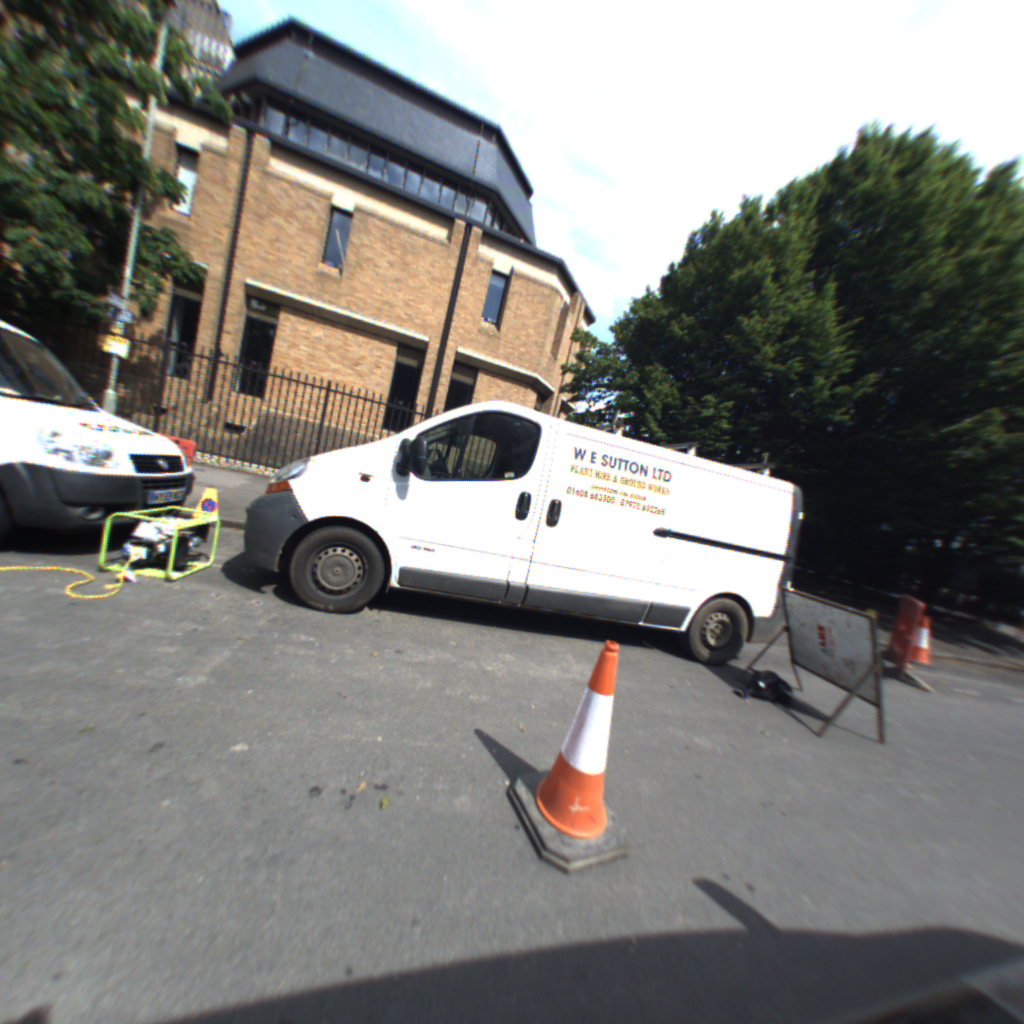

In [28]:
display(description)
Image.open(image_path)